In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Team members: Felipe Chen, Misha Semenov, Nick Shutov, Amareswar Doddi

In [2]:
# Loading the data
df = pd.read_csv('customer_segmentation_data.csv')
df.head()

,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,1,38,Female,99342,90,3,24,Groceries,113.53
1,2,21,Female,78852,60,2,42,Sports,41.93
2,3,60,Female,126573,30,2,28,Clothing,424.36
3,4,40,Other,47099,74,9,5,Home & Garden,991.93
4,5,65,Female,140621,21,3,25,Electronics,347.08


In [3]:
# Dropping irrelevant columns
df_dropped = df.drop(columns='id')
df_dropped

,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,38,Female,99342,90,3,24,Groceries,113.53
1,21,Female,78852,60,2,42,Sports,41.93
2,60,Female,126573,30,2,28,Clothing,424.36
3,40,Other,47099,74,9,5,Home & Garden,991.93
4,65,Female,140621,21,3,25,Electronics,347.08
...,...,...,...,...,...,...,...,...
995,57,Male,112170,57,6,1,Clothing,313.64
996,23,Other,65337,76,10,23,Groceries,632.83
997,23,Male,113097,40,5,42,Sports,75.09
998,22,Female,113695,63,7,44,Electronics,505.16


In [4]:
# Verifying the columns
df_dropped.columns

Index(['age', 'gender', 'income', 'spending_score', 'membership_years',
       'purchase_frequency', 'preferred_category', 'last_purchase_amount'],
      dtype='object')

In [5]:
# Checking if there's missing values
# Our group also have experience with imputations (average, median, mode) using SimpleImputer
# One advanced technique that could be used for other projects could be model based imputation.
df_dropped.isnull().sum()

,0
age,0
gender,0
income,0
spending_score,0
membership_years,0
purchase_frequency,0
preferred_category,0
last_purchase_amount,0


In [6]:
df_dropped.duplicated().sum()

np.int64(0)

In [7]:
# One Hot Encoder

enc = OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False)
X = enc.fit_transform(df_dropped[["gender",'preferred_category']])
cols = enc.get_feature_names_out(["gender",'preferred_category'])

# Put back into DataFrame

df = df_dropped.join(pd.DataFrame(X, columns=cols, index=df.index).astype(int))
df = df.drop(columns=['gender','preferred_category'])
df


,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports
0,38,99342,90,3,24,113.53,1,0,0,0,0,1,0,0
1,21,78852,60,2,42,41.93,1,0,0,0,0,0,0,1
2,60,126573,30,2,28,424.36,1,0,0,1,0,0,0,0
3,40,47099,74,9,5,991.93,0,0,1,0,0,0,1,0
4,65,140621,21,3,25,347.08,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,57,112170,57,6,1,313.64,0,1,0,1,0,0,0,0
996,23,65337,76,10,23,632.83,0,0,1,0,0,1,0,0
997,23,113097,40,5,42,75.09,0,1,0,0,0,0,0,1
998,22,113695,63,7,44,505.16,1,0,0,0,1,0,0,0


In [8]:
# One hot encoding were used instead of getting dummies, this help avoiding dropping columns.
# df_dummy = pd.get_dummies(df_dropped, columns=['gender','preferred_category'], drop_first=True, dtype=int)
# df_dummy

In [9]:
# Correlation for feature selection
df.corr()

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports
age,1.000000,-0.000688,0.017707,-0.003431,-0.030137,0.061599,0.004231,-0.066848,0.064080,0.030259,-0.024503,0.000364,-0.014686,0.011034
income,-0.000688,1.000000,0.000020,-0.035783,0.000533,-0.054006,-0.009589,0.008868,0.000446,0.011233,0.009339,-0.011792,0.005951,-0.014129
spending_score,0.017707,0.000020,1.000000,0.026726,0.006708,-0.014475,0.023749,-0.049080,0.026590,0.020196,-0.007004,0.009839,-0.027264,0.005866
membership_years,-0.003431,-0.035783,0.026726,1.000000,0.069532,-0.014135,-0.036325,0.025277,0.010184,0.004915,0.061542,-0.025739,-0.043846,0.002159
purchase_frequency,-0.030137,0.000533,0.006708,0.069532,1.000000,0.024400,-0.055953,0.089317,-0.035770,-0.029044,-0.006179,0.019774,-0.005172,0.018770
last_purchase_amount,0.061599,-0.054006,-0.014475,-0.014135,0.024400,1.000000,-0.078938,0.009431,0.068599,-0.004134,0.007584,-0.008548,0.022835,-0.018132
gender_Female,0.004231,-0.009589,0.023749,-0.036325,-0.055953,-0.078938,1.000000,-0.506459,-0.473786,0.013056,-0.015393,0.016787,0.015445,-0.028305
gender_Male,-0.066848,0.008868,-0.049080,0.025277,0.089317,0.009431,-0.506459,1.000000,-0.519392,-0.026060,-0.003836,-0.000225,0.017846,0.010402
gender_Other,0.064080,0.000446,0.026590,0.010184,-0.035770,0.068599,-0.473786,-0.519392,1.000000,0.013676,0.019173,-0.016407,-0.033533,0.017428
preferred_category_Clothing,0.030259,0.011233,0.020196,0.004915,-0.029044,-0.004134,0.013056,-0.026060,0.013676,1.000000,-0.236848,-0.225577,-0.230520,-0.233336


In [10]:

# Only income and spending_score were selected as feature because it represents a more distinctive feature
numeric_cols = ['income','spending_score'] #,'age','membership_years','purchase_frequency','last_purchase_amount']
cat_cols = ['gender_Male', 'gender_Other','gender_female', 'preferred_category_Electronics', 'preferred_category_Groceries','preferred_category_Home & Garden', 'preferred_category_Sports','preferred_category_Clothing']

df_scaled = df.copy()

# Scaling features to avoid feature dominance over another, this is mandatory specially for distance based algorithms.
scaler = StandardScaler()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

In [11]:
df_scaled

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports
0,38,0.316868,1.358468,3,24,113.53,1,0,0,0,0,1,0,0
1,21,-0.282016,0.321865,2,42,41.93,1,0,0,0,0,0,0,1
2,60,1.112778,-0.714738,2,28,424.36,1,0,0,1,0,0,0,0
3,40,-1.210096,0.805613,9,5,991.93,0,0,1,0,0,0,1,0
4,65,1.523374,-1.025718,3,25,347.08,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,57,0.691806,0.218205,6,1,313.64,0,1,0,1,0,0,0,0
996,23,-0.677034,0.874720,10,23,632.83,0,0,1,0,0,1,0,0
997,23,0.718900,-0.369203,5,42,75.09,0,1,0,0,0,0,0,1
998,22,0.736379,0.425525,7,44,505.16,1,0,0,0,1,0,0,0


In [12]:
X_scaled = df_scaled[numeric_cols]

# K-Means

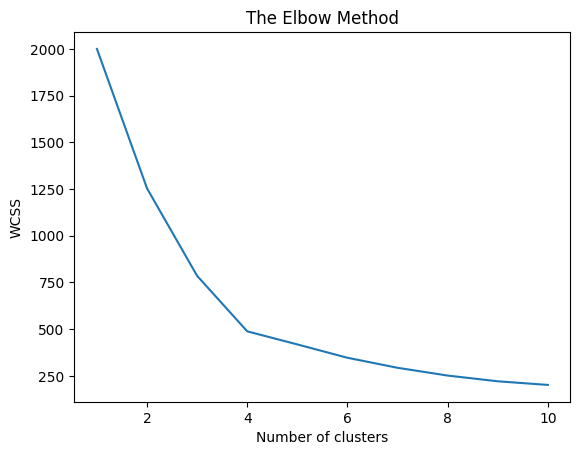

In [13]:
# Using the Elbow method to find the k cluster.

wcss = []

for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit(X_scaled)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [14]:
# Clusters seems to be the best (k=4)

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=500, random_state=42)
y = kmeans.fit_predict(X_scaled)
labels_kmeans = kmeans.labels_
labels_kmeans

array([3, 2, 1, 2, 1, 0, 2, 3, 0, 2, 0, 2, 2, 0, 1, 1, 1, 0, 3, 3, 0, 2,
       2, 2, 2, 3, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 3, 2, 0, 1, 0, 3, 0, 2,
       0, 1, 1, 2, 2, 3, 2, 3, 3, 2, 2, 2, 0, 1, 0, 1, 0, 2, 2, 0, 1, 3,
       3, 2, 3, 0, 2, 0, 1, 3, 3, 3, 0, 0, 1, 2, 3, 3, 3, 2, 1, 0, 0, 0,
       1, 2, 1, 3, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2,
       1, 2, 0, 0, 1, 3, 1, 0, 3, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 3,
       3, 2, 3, 1, 2, 3, 1, 2, 2, 0, 3, 2, 1, 1, 1, 3, 2, 1, 3, 0, 2, 0,
       3, 3, 2, 0, 3, 0, 1, 3, 2, 1, 1, 0, 2, 2, 2, 2, 1, 1, 3, 2, 2, 2,
       1, 3, 3, 1, 2, 1, 2, 0, 3, 3, 1, 0, 3, 2, 3, 1, 0, 2, 2, 1, 2, 3,
       0, 1, 1, 0, 1, 1, 3, 1, 2, 2, 1, 1, 2, 0, 1, 0, 3, 1, 0, 1, 2, 3,
       2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 3,
       1, 3, 1, 0, 0, 2, 3, 1, 1, 3, 1, 3, 3, 2, 1, 2, 2, 2, 3, 0, 3, 2,
       3, 2, 1, 1, 3, 2, 0, 1, 2, 3, 3, 0, 1, 0, 3, 2, 0, 0, 1, 0, 1, 3,
       3, 3, 2, 2, 0, 2, 2, 1, 3, 1, 1, 1, 0, 1, 1,

In [15]:
# Silhouette score is reasonable

score = silhouette_score(X_scaled, labels_kmeans)
print(score)

0.4189735063734962


In [16]:
# Add a new column with clusters (results) to my DataFrame
labels_kmeans = kmeans.labels_

df_scaled['Clusters'] = labels_kmeans
df_scaled.head(5)

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports,Clusters
0,38,0.316868,1.358468,3,24,113.53,1,0,0,0,0,1,0,0,3
1,21,-0.282016,0.321865,2,42,41.93,1,0,0,0,0,0,0,1,2
2,60,1.112778,-0.714738,2,28,424.36,1,0,0,1,0,0,0,0,1
3,40,-1.210096,0.805613,9,5,991.93,0,0,1,0,0,0,1,0,2
4,65,1.523374,-1.025718,3,25,347.08,1,0,0,0,1,0,0,0,1


<Axes: xlabel='Clusters', ylabel='count'>

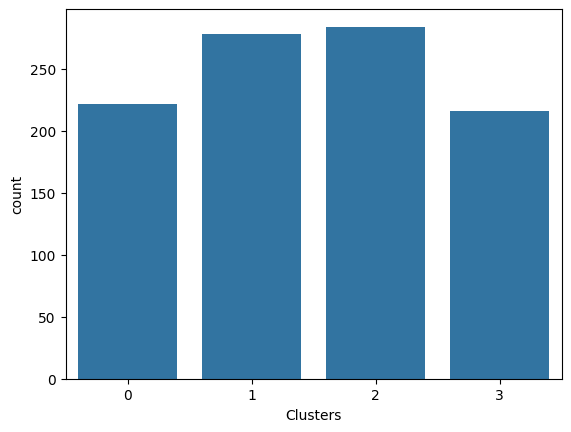

In [17]:
## Visualize Summary Statistics of Clusters
# Frequency of Clusters
sns.countplot(data=df_scaled, x='Clusters')

<Axes: xlabel='Clusters', ylabel='spending_score'>

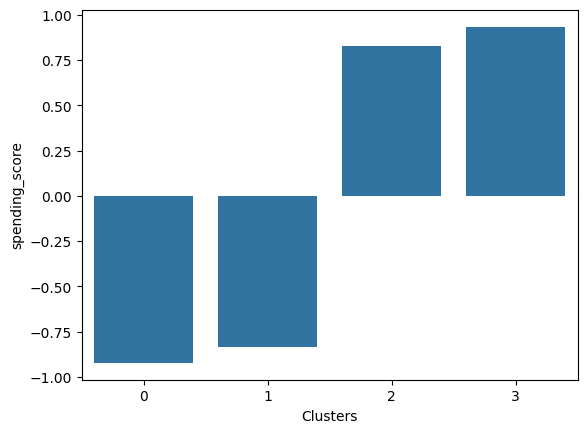

In [18]:
# Cluster vs mean spending_score
sns.barplot(data=df_scaled, x='Clusters', y='spending_score', errorbar=None, estimator='mean')

<Axes: xlabel='Clusters', ylabel='income'>

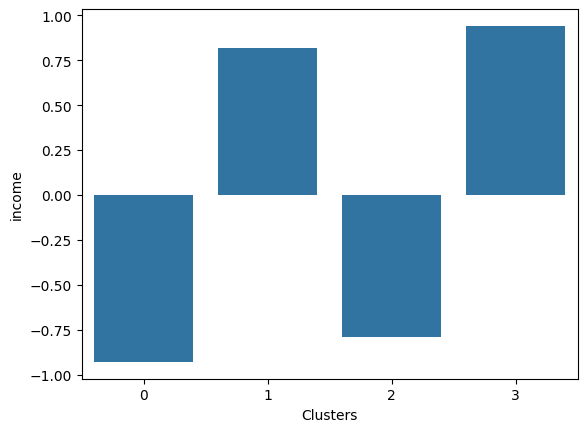

In [19]:
# Cluster vs Mean Income
sns.barplot(data=df_scaled, x='Clusters', y='income', errorbar=None, estimator='mean')

In [20]:
# Getting numerical summary of clusters
df_scaled.astype(float)
df_scaled.groupby('Clusters').mean().round(2)

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports
Clusters,,,,,,,,,,,,,,
0,43.32,-0.93,-0.92,5.45,26.53,508.29,0.32,0.37,0.32,0.18,0.22,0.18,0.23,0.20
1,43.59,0.82,-0.83,5.42,25.91,475.16,0.30,0.38,0.32,0.14,0.24,0.20,0.21,0.22
2,44.04,-0.79,0.83,5.61,26.71,501.86,0.33,0.33,0.34,0.17,0.20,0.20,0.20,0.24
3,44.19,0.94,0.93,5.36,27.39,485.58,0.32,0.35,0.33,0.20,0.21,0.22,0.19,0.18


- Cluster 0 - low income, low spend (−0.93, −0.92)
- Cluster 1 - high income, low spend (+0.82, −0.83)
- Cluster 2 - low income, high spend (−0.79, +0.83)
- Cluster 3 - high income, high spend (+0.94, +0.93)

In [21]:
# Visualize observations of that particular cluster (1)

df1_kmean = df_scaled[df_scaled['Clusters'].eq(1)].copy()
df1_kmean

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports,Clusters
2,60,1.112778,-0.714738,2,28,424.36,1,0,0,1,0,0,0,0,1
4,65,1.523374,-1.025718,3,25,347.08,1,0,0,0,1,0,0,0,1
14,33,0.694436,-1.163932,5,8,915.89,0,1,0,0,0,0,1,0,1
15,53,1.192015,-1.163932,6,26,225.40,0,1,0,1,0,0,0,0,1
16,57,0.410193,-0.749291,5,13,378.47,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,45,1.360457,-1.371253,9,42,422.93,1,0,0,1,0,0,0,0,1
980,30,0.843880,-0.645631,1,49,129.35,0,1,0,0,0,0,1,0,1
983,51,0.092980,-0.818398,9,49,990.87,0,0,1,0,1,0,0,0,1
997,23,0.718900,-0.369203,5,42,75.09,0,1,0,0,0,0,0,1,1


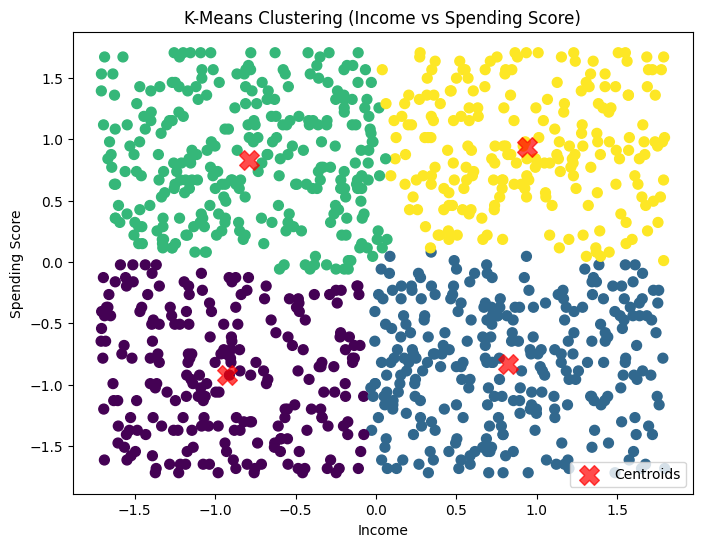

In [22]:
# Scatter plot of clusters
plt.figure(figsize=(8,6))
plt.scatter(X_scaled['income'], X_scaled['spending_score'],
            c=labels_kmeans,
            cmap='viridis',
            s=50)

# Plot centroids
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            c='red',
            s=200,
            alpha=0.7,
            marker='X',
            label='Centroids')

plt.title('K-Means Clustering (Income vs Spending Score)')
plt.xlabel('Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

# Hierarchical Clustering

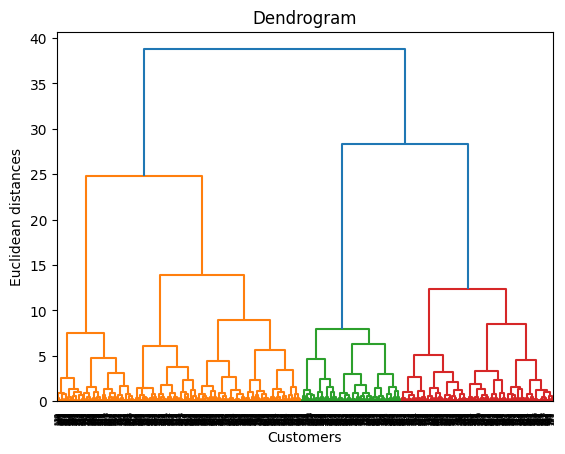

In [23]:
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(X_scaled, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [24]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = 5, metric = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_scaled)

In [44]:
# Silhouette Score is lower compared to K-means

print('Silhouette Score HC:', silhouette_score(X_scaled, y_hc))

Silhouette Score HC: 0.37411356233203535


In [25]:
df = df_scaled.copy()
df = df.drop(columns=['Clusters'])
df['HC_Cluster'] = pd.Series(y_hc, index=df.index).astype(int)  # one new column only
df

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports,HC_Cluster
0,38,0.316868,1.358468,3,24,113.53,1,0,0,0,0,1,0,0,2
1,21,-0.282016,0.321865,2,42,41.93,1,0,0,0,0,0,0,1,0
2,60,1.112778,-0.714738,2,28,424.36,1,0,0,1,0,0,0,0,4
3,40,-1.210096,0.805613,9,5,991.93,0,0,1,0,0,0,1,0,0
4,65,1.523374,-1.025718,3,25,347.08,1,0,0,0,1,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,57,0.691806,0.218205,6,1,313.64,0,1,0,1,0,0,0,0,2
996,23,-0.677034,0.874720,10,23,632.83,0,0,1,0,0,1,0,0,0
997,23,0.718900,-0.369203,5,42,75.09,0,1,0,0,0,0,0,1,1
998,22,0.736379,0.425525,7,44,505.16,1,0,0,0,1,0,0,0,2


In [26]:
# Summary Statistics of the hierarchical cluster
df.astype(float)
df.groupby('HC_Cluster').mean().round(2)

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports
HC_Cluster,,,,,,,,,,,,,,
0,43.68,-0.82,0.80,5.56,26.47,491.77,0.32,0.33,0.35,0.16,0.21,0.22,0.20,0.21
1,43.06,0.22,-0.69,5.39,25.47,488.99,0.34,0.31,0.35,0.20,0.21,0.17,0.21,0.21
2,44.97,0.99,0.92,5.38,27.19,486.63,0.33,0.35,0.32,0.20,0.20,0.21,0.20,0.18
3,43.56,-1.01,-1.15,5.78,27.41,513.55,0.28,0.42,0.29,0.16,0.23,0.18,0.20,0.22
4,43.61,1.32,-0.82,5.13,26.79,481.88,0.27,0.44,0.29,0.10,0.24,0.19,0.25,0.23


- Cluster 0 - low income, high spend (−0.82, +0.80)
- Cluster 1 - average income, low spend (+0.22, −0.69)
- Cluster 2 - high income, high spend (+0.99, +0.92)
- Cluster 3 - low income, low spend (-1.01, -1.15)
- Cluster 4 - high income, low spend (+1.32, -0.82)

Focus on Cluster 4, keep up with Cluster 2, and give more attention to cluster 1.

In [27]:
# Cluster 4: High Income, Low Spend
# Segment profile: High purchasing power but currently low engagement with our products/services.
# Key insight: Value-conscious / low-engagement affluent customers.
# Recommended strategy:
#   1.Targeted promotions and personalized offers to increase perceived value.
#   2. Cross-sell and up-sell campaigns tailored to their profile.
#   3. Test selective discounts or loyalty rewards to stimulate higher spending.
df4 = df[df['HC_Cluster'].eq(4)].copy()
df4

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports,HC_Cluster
2,60,1.112778,-0.714738,2,28,424.36,1,0,0,1,0,0,0,0,4
4,65,1.523374,-1.025718,3,25,347.08,1,0,0,0,1,0,0,0,4
14,33,0.694436,-1.163932,5,8,915.89,0,1,0,0,0,0,1,0,4
15,53,1.192015,-1.163932,6,26,225.40,0,1,0,1,0,0,0,0,4
46,56,1.183861,-0.369203,6,8,355.34,0,1,0,0,1,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,41,1.344089,-1.509466,10,50,556.10,0,0,1,0,1,0,0,0,4
953,44,1.032372,-1.060272,4,8,209.75,0,1,0,0,1,0,0,0,4
972,43,1.231795,-0.576524,10,5,833.69,0,1,0,0,0,1,0,0,4
979,45,1.360457,-1.371253,9,42,422.93,1,0,0,1,0,0,0,0,4


In [28]:
# Cluster 2: High Income, High Spend (Loyal/VIP Customers)
# Segment profile:
#   1. Customers with high purchasing power and strong spending levels.
#   2. Likely very valuable, loyal, and responsive to premium experiences.
# Business interpretation:
#   3. Core value segment: they drive a large share of revenue.
# Recommended strategy:
#   4. Preserve and grow: VIP programs, exclusive events, early access.
#   5. Personalized communication and premium services to strengthen loyalty.
#   6. Monitor churn risk closely (losing them has high revenue impact).

df2 = df[df['HC_Cluster'].eq(2)].copy()
df2

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports,HC_Cluster
0,38,0.316868,1.358468,3,24,113.53,1,0,0,0,0,1,0,0,2
7,43,0.573286,1.496681,9,27,734.56,0,1,0,0,0,1,0,0,2
18,37,0.204310,1.358468,6,21,454.83,0,1,0,0,0,0,1,0,2
19,31,0.251426,0.667399,3,17,61.30,0,1,0,0,0,1,0,0,2
25,33,1.556577,0.321865,10,39,83.27,0,0,1,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,68,0.838911,0.874720,7,38,363.94,1,0,0,0,1,0,0,0,2
987,26,1.752230,0.943827,5,14,99.19,0,1,0,0,0,1,0,0,2
992,22,1.080802,0.218205,8,27,139.75,1,0,0,0,0,0,1,0,2
995,57,0.691806,0.218205,6,1,313.64,0,1,0,1,0,0,0,0,2


In [29]:
# Cluster 1: Average Income, Low Spend
# Segment profile:
#   1. Customers with mid-level income but relatively low spending.
#   2. May be price-sensitive, low engagement, or not yet convinced of our value.
# Business interpretation:
#   3. "At-risk / under-engaged" segment with moderate potential.
# Recommended strategy:
#   4. Encourage trial and engagement with targeted, low-barrier offers (bundles, starter packs).
#   5. Educate them on benefits, product use cases, and value.
#   6. Use personalized recommendations to surface relevant, affordable options.

df1 = df[df['HC_Cluster'].eq(1)].copy()
df1

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports,HC_Cluster
16,57,0.410193,-0.749291,5,13,378.47,0,1,0,1,0,0,0,0,1
29,23,0.456110,-0.714738,4,20,950.56,0,1,0,0,1,0,0,0,1
35,30,-0.439497,-0.472864,1,6,532.51,1,0,0,1,0,0,0,0,1
38,31,-0.383145,-0.265543,4,29,88.44,1,0,0,0,0,0,0,1,1
39,22,0.542362,-1.267592,5,41,98.86,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,45,0.084183,-0.092776,8,16,253.13,1,0,0,0,0,0,0,1,1
983,51,0.092980,-0.818398,9,49,990.87,0,0,1,0,1,0,0,0,1
990,21,-0.240746,-0.334650,4,26,458.93,0,0,1,0,0,0,0,1,1
994,60,-0.484538,-0.887505,2,40,986.97,0,1,0,1,0,0,0,0,1


/tmp/ipython-input-2079051076.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df2, x=i, palette='pastel')


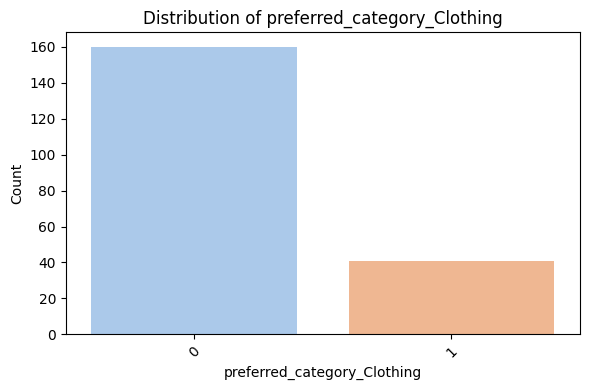

/tmp/ipython-input-2079051076.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df2, x=i, palette='pastel')


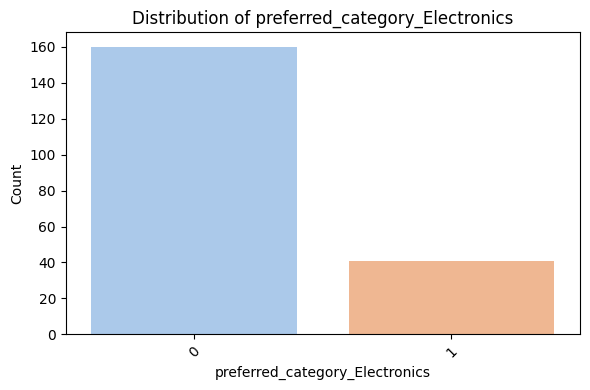

/tmp/ipython-input-2079051076.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df2, x=i, palette='pastel')


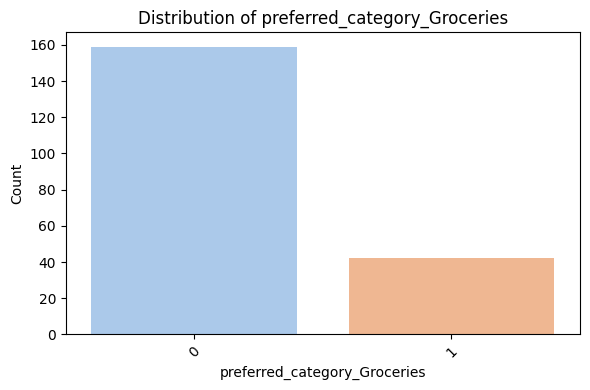

/tmp/ipython-input-2079051076.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df2, x=i, palette='pastel')


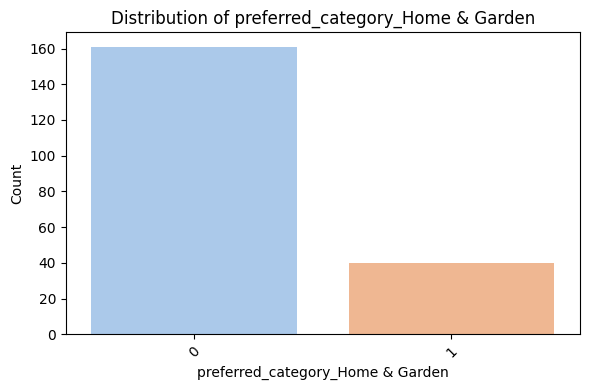

/tmp/ipython-input-2079051076.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df2, x=i, palette='pastel')


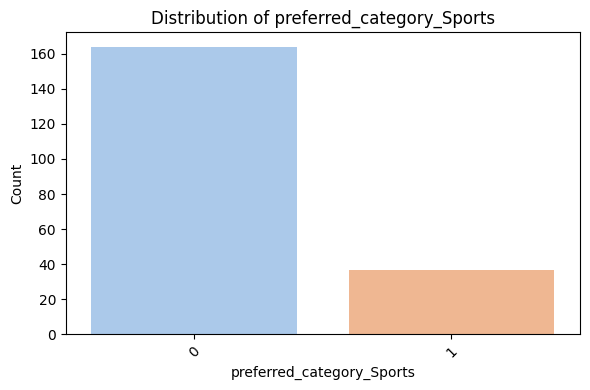

In [30]:
# Count of each category preferred, gender etc

preferred_categories = ['preferred_category_Clothing',
       'preferred_category_Electronics', 'preferred_category_Groceries',
       'preferred_category_Home & Garden', 'preferred_category_Sports']

for i in preferred_categories:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df2, x=i, palette='pastel')
    plt.title(f'Distribution of {i}', fontsize=12)
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-3693400126.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df4, x=i, palette='pastel')


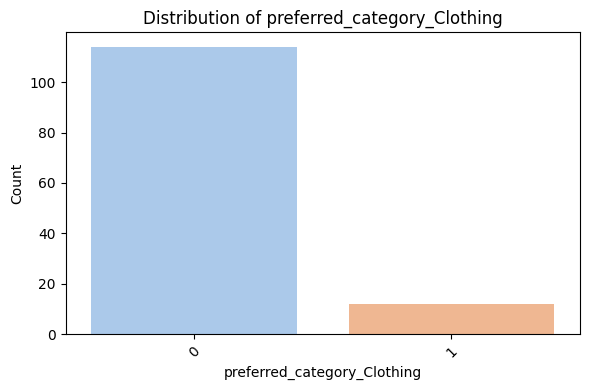

/tmp/ipython-input-3693400126.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df4, x=i, palette='pastel')


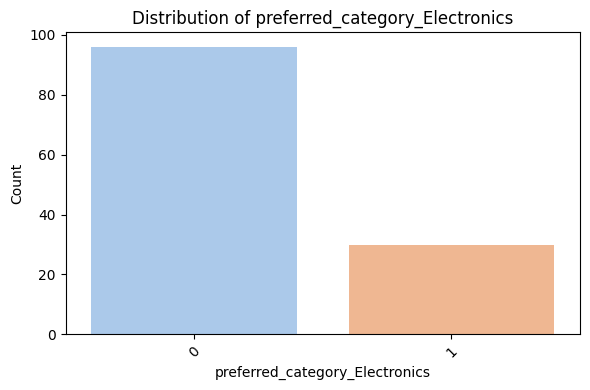

/tmp/ipython-input-3693400126.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df4, x=i, palette='pastel')


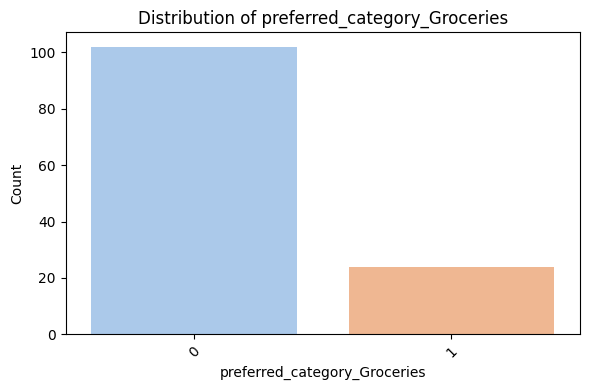

/tmp/ipython-input-3693400126.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df4, x=i, palette='pastel')


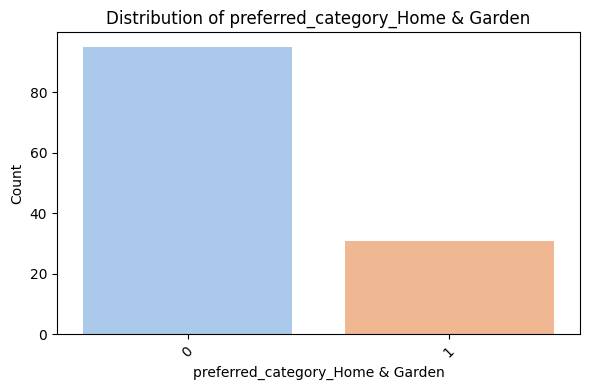

/tmp/ipython-input-3693400126.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df4, x=i, palette='pastel')


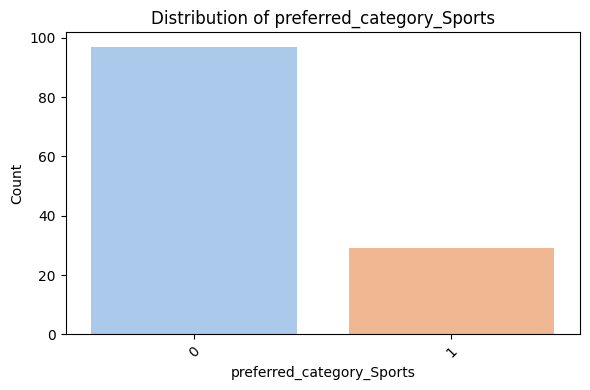

In [31]:
# Visualization on Preferred category

for i in preferred_categories:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df4, x=i, palette='pastel')
    plt.title(f'Distribution of {i}', fontsize=12)
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

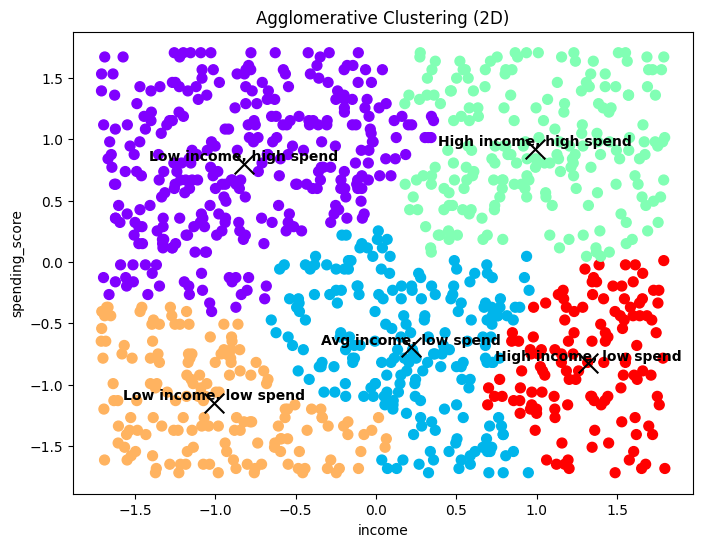

In [32]:
# Calculate cluster centroids (mean position per cluster)

# dataframe to array
x1 = X_scaled.iloc[:, 0].to_numpy()
x2 = X_scaled.iloc[:, 1].to_numpy()

centroids = []
for cluster_id in np.unique(y_hc):
    mask = y_hc == cluster_id
    cx, cy = x1[mask].mean(), x2[mask].mean()
    centroids.append((cluster_id, cx, cy))

cluster_labels = {
    0: "Low income, high spend",
    1: "Avg income, low spend",
    2: "High income, high spend",
    3: "Low income, low spend",
    4: "High income, low spend"
}


plt.figure(figsize=(8,6))
plt.scatter(x1, x2, c=y_hc, cmap='rainbow', s=50)
plt.title('Agglomerative Clustering (2D)')
plt.xlabel(X_scaled.columns[0])
plt.ylabel(X_scaled.columns[1])

# Add centroid labels
for cluster_id, cx, cy in centroids:
    plt.scatter(cx, cy, s=200, c='black', marker='x')  # centroid marker
    plt.text(cx, cy, cluster_labels[cluster_id], fontsize=10, ha='center', va='bottom', color='black', weight='bold')

plt.show()

In [33]:
# Future application: A/B Test to deploy a marketing strategy

# Decision Trees

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, classification_report, roc_auc_score,recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [35]:
# Getting a copy from the original dataset
df_dt = df_dropped.copy()
df_dt

,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,38,Female,99342,90,3,24,Groceries,113.53
1,21,Female,78852,60,2,42,Sports,41.93
2,60,Female,126573,30,2,28,Clothing,424.36
3,40,Other,47099,74,9,5,Home & Garden,991.93
4,65,Female,140621,21,3,25,Electronics,347.08
...,...,...,...,...,...,...,...,...
995,57,Male,112170,57,6,1,Clothing,313.64
996,23,Other,65337,76,10,23,Groceries,632.83
997,23,Male,113097,40,5,42,Sports,75.09
998,22,Female,113695,63,7,44,Electronics,505.16


In [36]:
# Assigning the cluster labels to the original dataset
df_dt['HC_Cluster'] = y_hc
df_dt

,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount,HC_Cluster
0,38,Female,99342,90,3,24,Groceries,113.53,2
1,21,Female,78852,60,2,42,Sports,41.93,0
2,60,Female,126573,30,2,28,Clothing,424.36,4
3,40,Other,47099,74,9,5,Home & Garden,991.93,0
4,65,Female,140621,21,3,25,Electronics,347.08,4
...,...,...,...,...,...,...,...,...,...
995,57,Male,112170,57,6,1,Clothing,313.64,2
996,23,Other,65337,76,10,23,Groceries,632.83,0
997,23,Male,113097,40,5,42,Sports,75.09,1
998,22,Female,113695,63,7,44,Electronics,505.16,2


In [37]:
# One Hot Encoder

enc = OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False)
X = enc.fit_transform(df_dt[["gender",'preferred_category']])
cols = enc.get_feature_names_out(["gender",'preferred_category'])

# Put back into your DataFrame

df_dt = df_dt.join(pd.DataFrame(X, columns=cols, index=df_dt.index).astype(int))
df_dt = df_dt.drop(columns=['gender','preferred_category'])
df_dt

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,HC_Cluster,gender_Female,gender_Male,gender_Other,preferred_category_Clothing,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports
0,38,99342,90,3,24,113.53,2,1,0,0,0,0,1,0,0
1,21,78852,60,2,42,41.93,0,1,0,0,0,0,0,0,1
2,60,126573,30,2,28,424.36,4,1,0,0,1,0,0,0,0
3,40,47099,74,9,5,991.93,0,0,0,1,0,0,0,1,0
4,65,140621,21,3,25,347.08,4,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,57,112170,57,6,1,313.64,2,0,1,0,1,0,0,0,0
996,23,65337,76,10,23,632.83,0,0,0,1,0,0,1,0,0
997,23,113097,40,5,42,75.09,1,0,1,0,0,0,0,0,1
998,22,113695,63,7,44,505.16,2,1,0,0,0,1,0,0,0


In [38]:
# Assigning features to X and target to y
# Decision Trees are scale invariant; therefore, scaling is not needed.
X = df_dt.drop('HC_Cluster',axis=1)
y = df_dt['HC_Cluster']

In [39]:
# Splitting the data into training (70%) and testing set (30%).
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [40]:
# To make the segmentation usable in practice, we trained a decision tree to predict the cluster label from the same features.
# # The tree achieved 100% accuracy on the training data and 97% on a held-out test set, indicating that the segments are well-separated and the rules generalize well.
# This is important to know that Decision Trees are only used in this example for better explainability.

model = DecisionTreeClassifier().fit(X_train, y_train)
y_dt_train = model.predict(X_train)

print('Accuracy Train:', accuracy_score(y_train, y_dt_train))

Accuracy Train: 1.0


In [41]:
y_pred = model.predict(X_test)

print('Accuracy Test:', accuracy_score(y_test, y_pred))

Accuracy Test: 0.9766666666666667


Text(0.5, 1.0, 'Confusion Matrix')

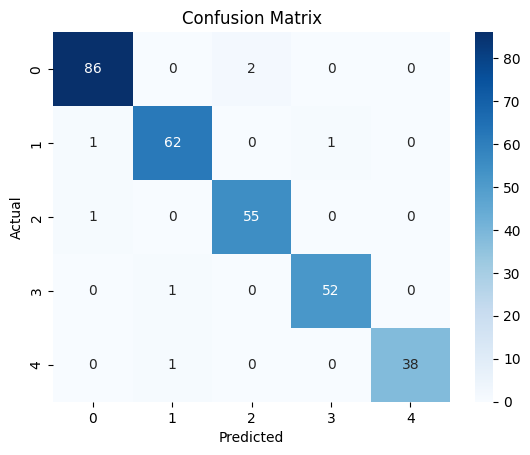

In [42]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

[Text(0.5217391304347826, 0.9, 'spending_score <= 52.5\ngini = 0.779\nsamples = 700\nvalue = [218, 145, 145, 105, 87]\nclass = 0'),
 Text(0.2826086956521739, 0.7, 'income <= 121199.0\ngini = 0.685\nsamples = 351\nvalue = [17, 141, 1, 105, 87]\nclass = 1'),
 Text(0.40217391304347827, 0.8, 'True  '),
 Text(0.17391304347826086, 0.5, 'income <= 68637.0\ngini = 0.574\nsamples = 271\nvalue = [17.0, 141.0, 0.0, 105.0, 8.0]\nclass = 1'),
 Text(0.08695652173913043, 0.3, 'spending_score <= 41.0\ngini = 0.315\nsamples = 106\nvalue = [17, 3, 0, 86, 0]\nclass = 3'),
 Text(0.043478260869565216, 0.1, '\n  (...)  \n'),
 Text(0.13043478260869565, 0.1, '\n  (...)  \n'),
 Text(0.2608695652173913, 0.3, 'spending_score <= 16.5\ngini = 0.285\nsamples = 165\nvalue = [0, 138, 0, 19, 8]\nclass = 1'),
 Text(0.21739130434782608, 0.1, '\n  (...)  \n'),
 Text(0.30434782608695654, 0.1, '\n  (...)  \n'),
 Text(0.391304347826087, 0.5, 'spending_score <= 51.0\ngini = 0.025\nsamples = 80\nvalue = [0, 0, 1, 0, 79]\nclas

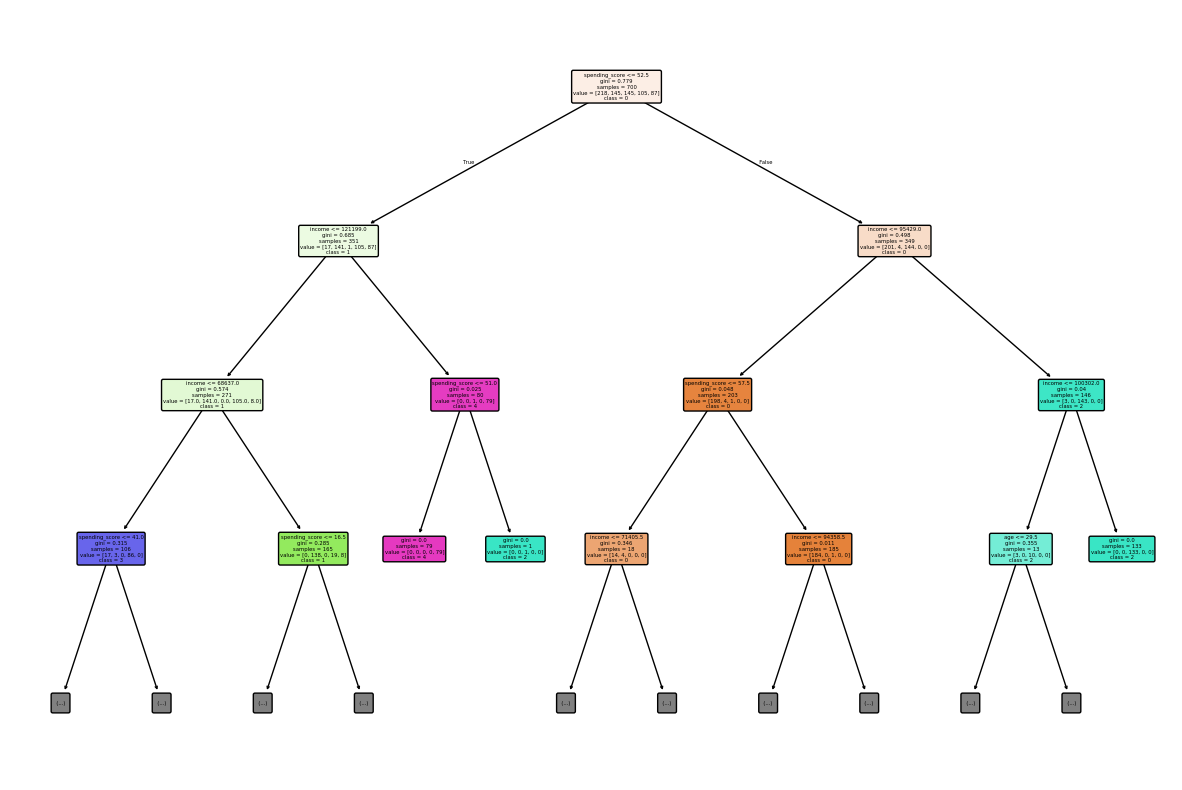

In [43]:
# This provides simple business rules (e.g., “If income > X and spending score < Y, then Segment B”) that marketing teams can use to assign new customers to segments in real time.
# This is also important because it can actually help modelers and business stakeholders to understand what features are really driving certain outcomes, which is something often required in the real world problem.
# Plot the tree
plt.figure(figsize=(15, 10))
plot_tree(
    model,
    max_depth=3,
    feature_names=X.columns,
    class_names=[str(c) for c in model.classes_],
    filled=True,
    rounded=True
)